## 1. Load the token-level annotations of PIEs

In [92]:
import pickle
import random
import sys
from data import Sentence
import pickle
import numpy as np
import torch
from transformers import MarianTokenizer, MarianMTModel
sys.path.append('../data/')
from classifier import Classifier
from collections import defaultdict
import tqdm
from intervene import generate
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib


annotations = dict()
pos_tags = dict()
for i in tqdm.tqdm_notebook(range(1727)):
    for l in open(f"../data/magpie/inputs/{i}.tsv", encoding="utf-8").readlines():
        s, annotation, _, _, _, pos_tags_ = l.split("\t")[:6]
        annotations[s] = [int(x) for x in annotation.split()]
        pos_tags[s] = pos_tags_.split()

random.seed(19)

/tmp/ipykernel_4441/4154259497.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(1727)):


  0%|          | 0/1727 [00:00<?, ?it/s]

## 2. Load short sentences that were no longer paraphrased after INLP.

In [93]:
examples = []

for language in ["nl", "de", "sv", "da", "fr", "it", "es"]:
    data = pickle.load(open(f"data/{language}/trace_{language}.pickle", 'rb'))[0]
    successes = []
    for s, x, y, l in zip(data["src"], data["before"], data["after"], data["new_labels"]):
        if l == "word-by-word" and len(s.sentence.split()) <= 20:
            successes.append((s.sentence, x, y, annotations[s.sentence], pos_tags[s.sentence], language))
    #src, tgt1, tgt2 = #
    #print(f"{src}\\\\\n{tgt1}\\\\\n{tgt2}\\\\\n\\midrule")
    examples.append(random.choice(successes))

In [94]:
def process(language, folds, sentence, indices_to_affect, noun_index):
    classifier = Classifier(
        f"../data/keywords/idiom_keywords_translated_{language}.tsv")
    mname = f"Helsinki-NLP/opus-mt-en-{language}"
    tokenizer = MarianTokenizer.from_pretrained(mname)
    model = MarianMTModel.from_pretrained(mname)
    model.eval()
    for fold in folds:
        hidden_projection_matrices = []
        attention_projection_matrices = []

        for layer in range(7):
            if layer in [0,1, 2, 3, 4]:
                P = pickle.load(
                    open(f"projection_matrices/{language}_hidden_fold={fold}_layer" +
                         f"={layer}_baseline=False_classifiers=50.pickle", 'rb'))
            else:
                P = None
            hidden_projection_matrices.append(P)
            attention_projection_matrices.append(None)

        # Translate without the projection matrices
        without_projection, attention_without = generate(
            model, tokenizer, sentence, gather_attention=True)

        # Translate with the projection matrices
        with_projection, attention_with = generate(
            model, tokenizer, sentence, projection=True,
            attention_projection_indices=[],
            attention_projection_matrices=attention_projection_matrices,
            hidden_projection_indices=torch.LongTensor(indices_to_affect),
            hidden_projection_matrices=hidden_projection_matrices,
            gather_attention=True)

        print(without_projection)
        print(with_projection)

        sns.set_context("talk")
        plt.figure(figsize=(4, 1))
        before = torch.FloatTensor(attention_without).squeeze(1).mean(0).mean(0)
        before = before[min(indices_to_affect):max(indices_to_affect) + 1, index]
        after = torch.FloatTensor(attention_with).squeeze(1).mean(0).mean(0)
        after = after[min(indices_to_affect):max(indices_to_affect) + 1, index]
        heatmap = (after - before) / after
        ax = sns.heatmap(heatmap.unsqueeze(-1).transpose(0, 1),
            cmap="coolwarm", vmin=-.3, vmax=.3)
        im = ax.collections[0]
        rgba_values = im.cmap(im.norm(im.get_array()))
        for x in rgba_values:
            print(matplotlib.colors.to_hex(x)[1:])
        plt.show()
        print(tokenizer.tokenize(sentence)[min(indices_to_affect):max(indices_to_affect) + 1])
        print(heatmap)

## 3. Print example sentences with the colour codes for how attention changes.

The trouble is, we don't see eye to eye, or, more correctly, our minds move in different channels.
Het probleem is dat we het niet met elkaar eens zijn... of dat onze geest in verschillende kanalen beweegt.</s>
Het probleem is, we zien geen oog tegen oog, of, meer correct, onze gedachten bewegen in verschillende kanalen.</s>
3b4cc0
f7ac8e
cad8ef
e9d5cb
b40426


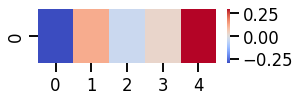

['▁see', '▁eye', '▁to', '▁eye', ',']
tensor([-0.3552,  0.1218, -0.0413,  0.0291,  0.3284])
A VISIT to Sellafield by the Fleetwood branch of the Salvation Army has broken new ground at the site.
Ein VISIT nach Sellafield durch den Fleetwood-Zweig der Heilsarmee hat am Standort neue Wege eingeschlagen.</s>
Ein VISIT nach Sellafield durch den Fleetwood-Zweig der Heilsarmee hat am Standort einen neuen Boden eingeschlagen.</s>
a6c4fe
ccd9ed
dddcdc


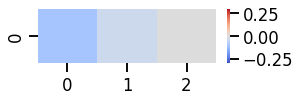

['▁broken', '▁new', '▁ground']
tensor([-0.1072, -0.0369,  0.0022])
( Vocal communication is out of the question till after the third cup of coffee. )
( Vokal kommunikation är uteslutet till efter den tredje koppen kaffe.)</s>
( Vokal kommunikation är ute ur frågan tills efter den tredje koppen kaffe.)</s>
3b4cc0
3b4cc0
aec9fc
eed0c0


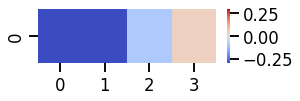

['▁out', '▁of', '▁the', '▁question']
tensor([-0.4543, -0.3193, -0.0937,  0.0464])
But responsive, strategic managership is absent across the board in Britain.
Men lydhør, strategisk lederskab er fraværende over hele linjen i Storbritannien.</s>
Men lydhør, strategisk lederskab er fraværende på tværs af bestyrelsen i Storbritannien.</s>
3b4cc0
9dbdff
e3d9d3


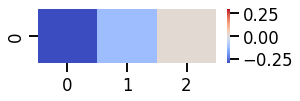

['▁across', '▁the', '▁board']
tensor([-0.3355, -0.1228,  0.0141])
We stopped beside a autobank, which was out of order.
Nous nous sommes arrêtés à côté d'une autobanque, ce qui était hors service.</s>
Nous nous sommes arrêtés à côté d'une autobanque, ce qui n'était pas de l'ordre.</s>
3b4cc0
4055c8
f7b093
d95847


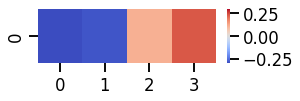

['▁out', '▁of', '▁order', '.']
tensor([-0.6019, -0.2865,  0.1138,  0.2332])
The two went hand in hand until the later nineteenth century.
I due andarono di pari passo fino al XIX secolo.</s>
I due sono andati mano nella mano fino al XIX secolo successivo.</s>
4961d2
c4d5f3
e5d8d1
f7b194


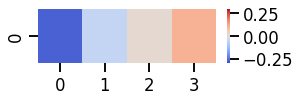

['▁went', '▁hand', '▁in', '▁hand']
tensor([-0.2709, -0.0533,  0.0202,  0.1120])
Then, brisk again, ' I 'll bear it in mind. '
Entonces, rápido de nuevo, ' Lo tendré en cuenta. '</s>
Entonces, anímate de nuevo, 'Lo tendré en mente'.</s>
3b4cc0
f4c6af
3b4cc0
f7b194
b40426


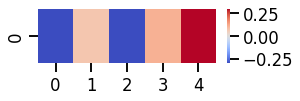

['▁bear', '▁it', '▁in', '▁mind', '.']
tensor([-0.3589,  0.0717, -0.7764,  0.1120,  0.4138])


In [95]:
for src, tgt1, tgt2, annotation, tag_set, language in examples:
    print(src)
    mname = f"Helsinki-NLP/opus-mt-en-{language}"
    tokenizer = MarianTokenizer.from_pretrained(mname)
    tokenised_annotations = []
    tokenised_pos_tags = []
    for w, a, p in zip(src.split(), annotation, tag_set):
        tokenised_annotations.extend([a] * len(tokenizer.tokenize(w)))
        if "suit" in w:
            p = "NOUN"
        tokenised_pos_tags.extend([p] + [None] * (len(tokenizer.tokenize(w)) - 1))
    indices_to_affect = [i for i, x in enumerate(tokenised_annotations) if x == 1]
    index = [i for i, (x, p) in enumerate(zip(tokenised_annotations, tokenised_pos_tags)) if x == 1 and p == "NOUN"][0]
    process(language, [0], src, indices_to_affect, index)

### Color bar to put on top of the figure

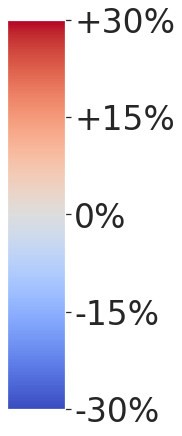

In [114]:
import pylab as pl
import numpy as np
sns.set(font_scale=3)
a = np.array([[0,1]])
pl.figure(figsize=(1, 9))
img = pl.imshow(a, cmap="coolwarm")
pl.gca().set_visible(False)
cax = pl.axes([-0.1, 0.2, 0.8, 0.6])
ax = pl.colorbar(orientation="vertical", cax=cax, ticks=[0, 0.25, 0.5, 0.75, 1])
ax.ax.set_yticklabels(["-30%", "-15%", "0%", "+15%", "+30%"])
pl.savefig("colorbar.png", transparent=True, bbox_inches="tight")